#### RNN, LSTM, GRU classification of mouse wheel movement based on Steinmetz `spks` dataset and code from [nma](https://deeplearning.neuromatch.io/projects/Neuroscience/neuro_seq_to_seq.html)

This notebook uses the full time sequence of neural data instead of slicing off data below 500ms and above 1500ms. This increases the sequence depth to 250 hidden units, which I postulate will affect training in RNN and possibly LSTM and GRU as well.

Also, from the [Daily Guide for Projects](https://deeplearning.neuromatch.io/projects/docs/project_guidance.html#w3d3-and-w3d4-3h-day-results) page,

_Did you accidentally select only neurons that were tuned to a behavior, and then showed that they respond to aspects of that behavior? Did you sort neurons by their peak response time and then found sequences in your data? That is circular reasoning! There are some obvious and some not-so-obvious circular analyses that can catch even experienced researchers off-guard. This is what the controls are especially useful at catching._

__Note__: _You must restart the notebook_ for training the LSTM and GRU models and each time you rerun a model. This appears to be an issue of the previous model remaining on the GPU after training.

##### Imports

In [1]:
# Imports
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, io, models, ops, transforms, utils
from matplotlib import pyplot as plt

##### Device

In [2]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

##### Set random seed

In [3]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


##### Data retrieval

In [5]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [6]:
# data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

##### Select recording 11

In [7]:
# select recording 11
dat = alldat[11]

##### Format dataset
An RNN has specific data requirements fed into the network for training, testing, and prediction. The depth of the network in a time or data series is given by `hidden_size`. In the case of the `spks` dataset this is 250 because one trial lasts for this many samples. These are the 250 sequenced datapoints related to the same mouse event trial from the same probe sensor size of 698 neurons over a time period of 2500ms. Further mouse trials are added in sequence in the dataset, where the training and forward algorithms reset to the start of the RNN. This dataset is then 698 neurons wide with 250 datapoints and 340 trials in length, before being split into train and test sets.

In [8]:
def shuffle_dataset(X, y):
  """
  Helper function to shuffle and split data
  Assumes that set_seed has already been run

  Args:
    X: torch.tensor
      Input data trials X time samples X neurons
    y: torch.tensor
      Corresponding one hot target variables as trials x categories
      
  Returns:
    X: torch.tensor
    y: torch.tensor
  """

  # Number of trials
  N = X.shape[0]

  # Shuffle data
  shuffled_indices = np.random.permutation(N) 
  X = X[shuffled_indices, :, :]
  y = y[shuffled_indices, :]
  
  return X, y

In [9]:
# data are neurons X trials x time samples, but permute to trials X time samples X neurons
x = torch.tensor(dat['spks']).permute(1,2,0)
# x = x[:,50:150,:]

# response is -1, 0, 1, but convert to one hot where 2 takes the place of -1 to satisfy torch one hot
dat['response'][dat['response'] == -1] = 2 
y = torch.as_tensor(dat['response']).long()
y = F.one_hot(y)

# shuffle dataset before split
x, y = shuffle_dataset(x, y)

# split into train (70%), validation(20%) and test(10%) sets using batch size of 34
n_trials = int(x.shape[0])
ntr = int(n_trials * 7 / 10)
nv = int(n_trials * 2 / 10) + ntr

X_train = x[:ntr, :, :].to(device).float()
X_val = x[ntr:nv, :, :].to(device).float()
X_test = x[nv:, :, :].to(device).float()

y_train = y[:ntr].to(device).float()
y_val = y[ntr:nv].to(device).float()
y_test = y[nv:].to(device).float()

In [10]:
print(y[0])
print(x.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

tensor([0, 0, 1])
torch.Size([340, 250, 698])
torch.Size([340, 3])
torch.Size([238, 250, 698])
torch.Size([238, 3])
torch.Size([68, 250, 698])
torch.Size([68, 3])
torch.Size([34, 250, 698])
torch.Size([34, 3])


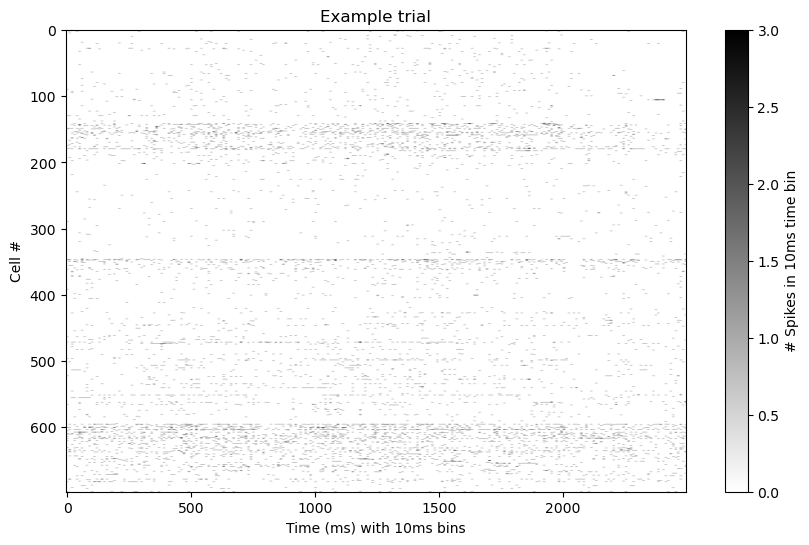

In [11]:
##### Visualise data from one trial to show time slicing
plt.figure(figsize = (10, 6))
plt.imshow(x[0,:,:].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xticks([0, 50, 100, 150, 200], [0, 500, 1000, 1500, 2000]) 
# plt.xticks([0, 20, 40, 60, 80], [500, 700, 900, 1100, 1300]) 
plt.xlabel('Time (ms) with 10ms bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 10ms time bin')
plt.title('Example trial')
plt.show()

##### Dataloader

In [12]:
# batch_size of 34 used to match number of trials
batch_size = 34

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Hyperparameters

In [13]:
# number of hidden RNN stages, inputs and outputs
hidden_size = x.shape[1]
input_size = x.shape[2]
output_size = y_train.shape[1]
num_layers = 1
learning_rate = 0.001
number_of_epochs = 1000
RNN_number_of_epochs = 300
LSTM_number_of_epochs = 200
GRU_number_of_epochs = 150

# early stopping not used
# RNN_patience = 5
# LSTM_patience = 5
# GRU_patience = 5

In [14]:
print(hidden_size)
print(input_size)
print(output_size)

250
698
3


##### Define RNN
Since the `hidden_size` is 250 we can expect to see either exploding or vanishing gradients in the RNN. For this case we can't expect the RNN to be able to predict well. But, as Dev did, we can reduce the `hidden_size` by slicing off data which doesn't correspond to wheel movement. 

In [15]:
# chatgpt 3.5 generated code
# RNN Model with Softmax
class RNNWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layer to map RNN output to class labels
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)

        # Use only the last time step's output for classification
        out = self.fc(out[:, -1, :]) 

        # Apply softmax activation
        return nn.functional.softmax(out, dim=1)  

##### Train the RNN: setup

In [16]:
# chatgpt 3.5 generated code
model = RNNWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### Train the RNN and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/300], Training Loss: 1.07631499, Training Accuracy: 0.4034
Epoch [1/300], Validation Loss: 1.07888329, Validation Accuracy: 0.3235
Epoch [2/300], Training Loss: 0.97536441, Training Accuracy: 0.6807
Epoch [2/300], Validation Loss: 1.05245477, Validation Accuracy: 0.4559
Epoch [3/300], Training Loss: 0.86998096, Training Accuracy: 0.8193
Epoch [3/300], Validation Loss: 1.04843676, Validation Accuracy: 0.5147
Epoch [4/300], Training Loss: 0.72118998, Training Accuracy: 0.9076
Epoch [4/300], Validation Loss: 1.03596839, Validation Accuracy: 0.4118
Epoch [5/300], Training Loss: 0.60659612, Training Accuracy: 0.9748
Epoch [5/300], Validation Loss: 1.04691499, Validation Accuracy: 0.4265
Epoch [6/300], Training Loss: 0.57127206, Training Accuracy: 1.0000
Epoch [6/300], Validation Loss: 1.08985078, Validation Accuracy: 0.4118
Epoch [7/300], Training Loss: 0.55662974, Training Accuracy: 1.0000
Epoch [7/300], Validation Loss: 1.06396765, Validation Accuracy: 0.4265
Epoch [8/300], Train

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch [296/300], Training Loss: 0.55144820, Training Accuracy: 1.0000
Epoch [296/300], Validation Loss: 1.02600551, Validation Accuracy: 0.5147
Epoch [297/300], Training Loss: 0.55144818, Training Accuracy: 1.0000
Epoch [297/300], Validation Loss: 1.02604142, Validation Accuracy: 0.5147
Epoch [298/300], Training Loss: 0.55144813, Training Accuracy: 1.0000
Epoch [298/300], Validation Loss: 1.02592918, Validation Accuracy: 0.5147
Epoch [299/300], Training Loss: 0.55144812, Training Accuracy: 1.0000
Epoch [299/300], Validation Loss: 1.02594820, Validation Accuracy: 0.5147
Epoch [300/300], Training Loss: 0.55144813, Training Accuracy: 1.0000
Epoch [300/300], Validation Loss: 1.02596924, Validation Accuracy: 0.5147


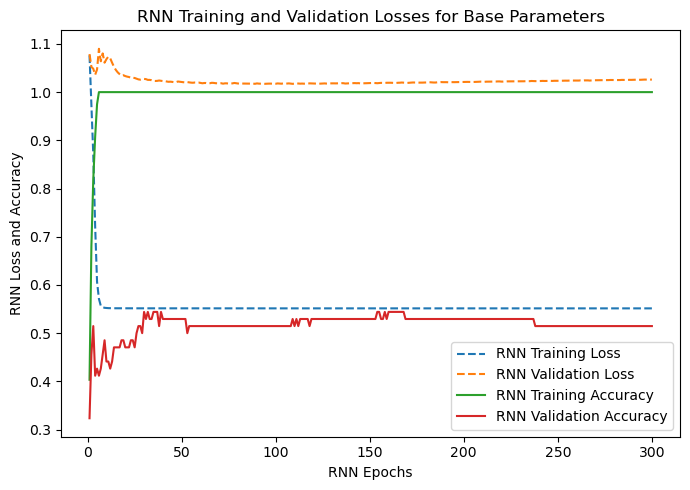

In [17]:
# chatgpt 3.5 generated code
# Training loop
# RNN_total_epochs = number_of_epochs
RNN_total_epochs = RNN_number_of_epochs

# Early stopping parameters
# best_val_loss = float('inf')
# epochs_since_best = 0

# Number of epochs to wait for improvement in validation loss
# patience = RNN_patience

# Lists to store training/validation losses and training/validation accuracies
RNN_train_losses = []  
RNN_val_losses = []    
RNN_train_accuracies = []  
RNN_val_accuracies = []    

for epoch in range(RNN_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    RNN_train_losses.append(average_train_loss)
    RNN_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Check if validation loss has improved
    # if average_val_loss < best_val_loss:
    #    best_val_loss = average_val_loss
    #    epochs_since_best = 0
    # else:
    #    epochs_since_best += 1

    # Store validation loss and accuracy values
    RNN_val_losses.append(average_val_loss)
    RNN_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{RNN_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    # if epochs_since_best >= patience:
    #    print(f"Early stopping at epoch {epoch + 1}. Validation loss did not improve for {patience} epochs.")
    #    break

# Plot the losses and accuracies at the end of all epochs
RNN_x_epochs = list(range(1, RNN_total_epochs + 1))
plt.figure(figsize=(7, 5))

# Plot losses (dashed) and accuracies (solid)
plt.plot(RNN_x_epochs, RNN_train_losses, linestyle='--', label='RNN Training Loss')
plt.plot(RNN_x_epochs, RNN_val_losses, linestyle='--', label='RNN Validation Loss')
plt.plot(RNN_x_epochs, RNN_train_accuracies, label='RNN Training Accuracy')
plt.plot(RNN_x_epochs, RNN_val_accuracies, label='RNN Validation Accuracy')
plt.xlabel('RNN Epochs')
plt.ylabel('RNN Loss and Accuracy')
plt.title('RNN Training and Validation Losses for Base Parameters')
plt.legend()

plt.tight_layout()
plt.savefig('eps/RNN_11_full_time_seq_spks_class.eps')
plt.savefig('svg/RNN_11_full_time_seq_spks_class.svg')
plt.show()

##### Testing 

In [18]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.44118


##### Analysis RNN
Validation accuracy is 0.5147 at 300 epochs. Test accuracy is 0.44118.

##### Define LSTM

In [15]:
# chatgpt 3.5 generated code
# LSTM Model with Softmax
class LSTMWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train LSTM: setup 

In [16]:
# chatgpt 3.5 generated code
model = LSTMWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the LSTM and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/200], Training Loss: 1.08062606, Training Accuracy: 0.3697
Epoch [1/200], Validation Loss: 1.08021361, Validation Accuracy: 0.3088
Epoch [2/200], Training Loss: 1.03656725, Training Accuracy: 0.4496
Epoch [2/200], Validation Loss: 1.11488158, Validation Accuracy: 0.3088
Epoch [3/200], Training Loss: 1.03056371, Training Accuracy: 0.5168
Epoch [3/200], Validation Loss: 1.05256945, Validation Accuracy: 0.4853
Epoch [4/200], Training Loss: 0.98078582, Training Accuracy: 0.7437
Epoch [4/200], Validation Loss: 1.05882221, Validation Accuracy: 0.3529
Epoch [5/200], Training Loss: 0.92371413, Training Accuracy: 0.6303
Epoch [5/200], Validation Loss: 1.01551455, Validation Accuracy: 0.4853
Epoch [6/200], Training Loss: 0.88553567, Training Accuracy: 0.6975
Epoch [6/200], Validation Loss: 1.06844285, Validation Accuracy: 0.3382
Epoch [7/200], Training Loss: 0.86093283, Training Accuracy: 0.7563
Epoch [7/200], Validation Loss: 0.98729905, Validation Accuracy: 0.5882
Epoch [8/200], Train

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch [200/200], Training Loss: 0.55145053, Training Accuracy: 1.0000
Epoch [200/200], Validation Loss: 0.80575743, Validation Accuracy: 0.7353


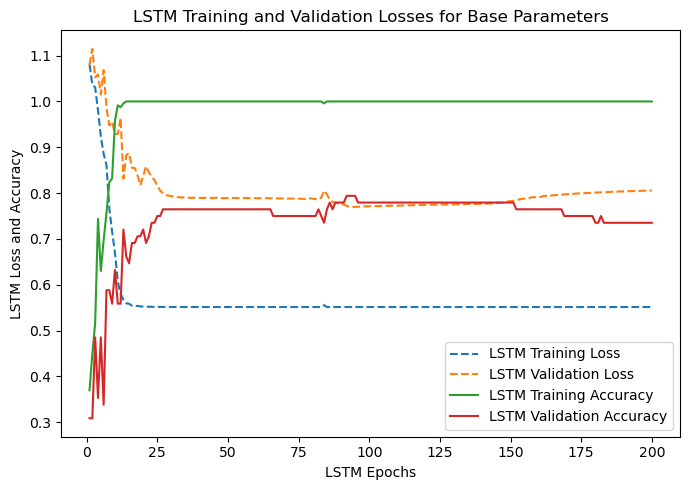

In [17]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# LSTM_total_epochs = number_of_epochs
LSTM_total_epochs = LSTM_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
LSTM_train_losses = []  
LSTM_val_losses = []    
LSTM_train_accuracies = []  
LSTM_val_accuracies = []    

for epoch in range(LSTM_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    LSTM_train_losses.append(average_train_loss)
    LSTM_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    LSTM_val_losses.append(average_val_loss)
    LSTM_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{LSTM_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
LSTM_x_epochs = list(range(1, LSTM_total_epochs + 1))
plt.figure(figsize=(7, 5))

# Plot losses (dashed) and accuracies (solid)
plt.plot(LSTM_x_epochs, LSTM_train_losses, linestyle='--', label='LSTM Training Loss')
plt.plot(LSTM_x_epochs, LSTM_val_losses, linestyle='--', label='LSTM Validation Loss')
plt.plot(LSTM_x_epochs, LSTM_train_accuracies, label='LSTM Training Accuracy')
plt.plot(LSTM_x_epochs, LSTM_val_accuracies, label='LSTM Validation Accuracy')
plt.xlabel('LSTM Epochs')
plt.ylabel('LSTM Loss and Accuracy')
plt.title('LSTM Training and Validation Losses for Base Parameters')
plt.legend()

plt.tight_layout()
plt.savefig('eps/LSTM_11_full_time_seq_spks_class.eps')
plt.savefig('svg/LSTM_11_full_time_seq_spks_class.svg')
plt.show()

##### Testing 

In [18]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.64706


##### Analysis LSTM
Validation accuracy is 0.7353 at 200 epochs. Test accuracy is 0.64706.



##### Define GRU

In [15]:
# chatgpt 3.5 generated code
# GRU Model with Softmax
class GRUWithSoftmax(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUWithSoftmax, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for classification
        return nn.functional.softmax(out, dim=1)  # Apply softmax activation

##### Train GRU: setup 

In [16]:
# chatgpt 3.5 generated code
model = GRUWithSoftmax(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the GRU and plot training and validation losses and accuracies
Note that the trained model seems to remain resident on the graphics card unless we restart the notebook.

Epoch [1/150], Training Loss: 1.08034233, Training Accuracy: 0.3697
Epoch [1/150], Validation Loss: 1.07192999, Validation Accuracy: 0.2941
Epoch [2/150], Training Loss: 1.03080586, Training Accuracy: 0.4412
Epoch [2/150], Validation Loss: 1.05954367, Validation Accuracy: 0.4265
Epoch [3/150], Training Loss: 0.98479665, Training Accuracy: 0.7101
Epoch [3/150], Validation Loss: 1.05060619, Validation Accuracy: 0.5294
Epoch [4/150], Training Loss: 0.93421638, Training Accuracy: 0.7521
Epoch [4/150], Validation Loss: 1.06340206, Validation Accuracy: 0.3824
Epoch [5/150], Training Loss: 0.85428699, Training Accuracy: 0.7311
Epoch [5/150], Validation Loss: 0.98255637, Validation Accuracy: 0.5294
Epoch [6/150], Training Loss: 0.76180556, Training Accuracy: 0.7899
Epoch [6/150], Validation Loss: 1.00334880, Validation Accuracy: 0.5147
Epoch [7/150], Training Loss: 0.70992163, Training Accuracy: 0.8866
Epoch [7/150], Validation Loss: 0.96930102, Validation Accuracy: 0.5147
Epoch [8/150], Train

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


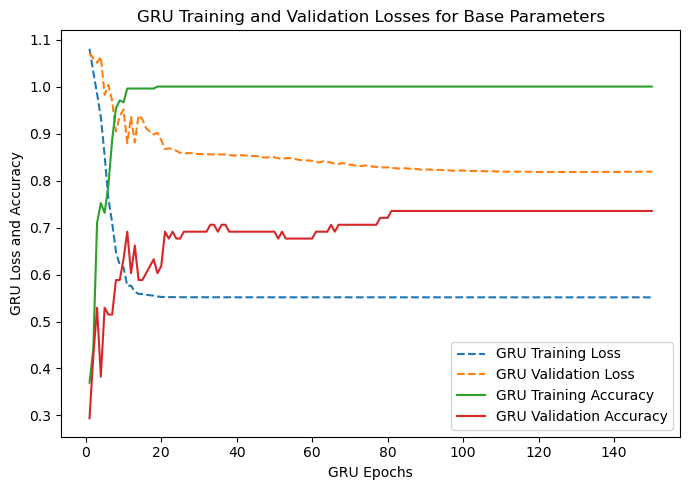

In [17]:
# chatgpt 3.5 generated code (this code is a copy of the RNN code)
# Training loop
# GRU_total_epochs = number_of_epochs
GRU_total_epochs = GRU_number_of_epochs

# Lists to store training/validation losses and training/validation accuracies
GRU_train_losses = []  
GRU_val_losses = []    
GRU_train_accuracies = []  
GRU_val_accuracies = []    

for epoch in range(GRU_total_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, one_hot_labels in train_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the total training loss for this epoch
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
        total_train += one_hot_labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    average_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy values
    GRU_train_losses.append(average_train_loss)
    GRU_train_accuracies.append(train_accuracy)
    
    # Print the training loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Training Loss: {average_train_loss:.8f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, one_hot_labels in val_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)
            
            # Forward pass (validation)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(one_hot_labels, dim=1))
            
            # Update the total validation loss for this epoch
            total_val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == torch.argmax(one_hot_labels, dim=1)).sum().item()
            total_val += one_hot_labels.size(0)
    
    # Calculate average validation loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy values
    GRU_val_losses.append(average_val_loss)
    GRU_val_accuracies.append(val_accuracy)
    
    # Print the validation loss and accuracy for this epoch
    print(f'Epoch [{epoch+1}/{GRU_total_epochs}], Validation Loss: {average_val_loss:.8f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot the losses and accuracies at the end of all epochs
GRU_x_epochs = list(range(1, GRU_total_epochs + 1))
plt.figure(figsize=(7, 5))

# Plot losses (dashed) and accuracies (solid)
plt.plot(GRU_x_epochs, GRU_train_losses, linestyle='--', label='GRU Training Loss')
plt.plot(GRU_x_epochs, GRU_val_losses, linestyle='--', label='GRU Validation Loss')
plt.plot(GRU_x_epochs, GRU_train_accuracies, label='GRU Training Accuracy')
plt.plot(GRU_x_epochs, GRU_val_accuracies, label='GRU Validation Accuracy')
plt.xlabel('GRU Epochs')
plt.ylabel('GRU Loss and Accuracy')
plt.title('GRU Training and Validation Losses for Base Parameters')
plt.legend()

plt.tight_layout()
plt.savefig('eps/GRU_11_full_time_seq_spks_class.eps')
plt.savefig('svg/GRU_11_full_time_seq_spks_class.svg')
plt.show()

##### Testing

In [19]:
# chatgpt 3.5 generated code
# Test the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, one_hot_labels in test_loader:
        inputs = inputs.to(device)
        one_hot_labels = one_hot_labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(one_hot_labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.73529


##### Analysis GRU
Validation accuracy is 0.7353 at 150 epochs. Test accuracy is 0.73529.

##### Final notes
__250 time bins__
|  | epochs | validation accuracy (%) | test accuracy (%) | time (s) |
| --- | --- | ---| --- | --- |
| RNN | 300 | 51.47 | 44.118 | 9.6 |
| LSTM | 200 | 73.53 | 64.706 | 34.0 |
| GRU | 150 | 73.53 | 73.529 | 24.6 |

__100 time bins__
|  | epochs | validation accuracy (%) | test accuracy (%) | time (s) |
| --- | --- | ---| --- | --- |
| RNN | 70 | 84.91 | 85.714 | 1.5 |
| LSTM | 100 | 84.91 | 82.143 | 2.3 |
| GRU | 60 | 86.76 | 85.714 | 1.4 |

The GRU performed the best of the group, training to a test accuracy of 73.529%, but when compared with the time series depth of 100 time bins with a test accuracy of 85.714% its accuracy is about 12% lower.

The LSTM dropped another 8.8% and the RNN dropped to an almost equal half of its 100 time bin value.

The number of epochs for all methods substantially increased for the 250 time bin series, possibly reflecting a greater difficulty in finding the parts of the time series which are significant in predicting a response from the mouse. The RNN wasn't capable of doing this and the LSTM struggled.

...